In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
LB = np.zeros((16, 16))
LB[4:, :4] = 2
    
LB[3:10, 8:] = 1
LB[[3, 4, 3],[8, 8, 9]] = 0
LB[[8, 9, 9],[8, 8, 9]] = 0
LB[[3, 4, 3],[-2, -1, -1]] = 0
LB[[9, 8, 9],[-2, -1, -1]] = 0
    
LB[12:-1, 6:9] = 3

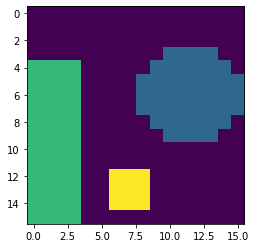

In [3]:
plt.imshow(LB);

In [9]:
def area(LB, label=1):
    pxs = np.where(LB == label)
    return len(pxs[0])

In [10]:
print(area(LB, 1))
print(area(LB, 2))
print(area(LB, 3))

44
48
9


In [15]:
def centroid(LB, label=1):
    pxs = np.where(LB == label)
    return (np.mean(pxs[0]), np.mean(pxs[1]))

In [17]:
print(centroid(LB, 1))
print(centroid(LB, 2))
print(centroid(LB, 3))

(6.0, 11.5)
(9.5, 1.5)
(13.0, 7.0)


In [28]:
def neighbours(y, x):
    return (y, x+1), (y+1, x), (y, x-1), (y-1, x)

def get_boundaries(LB, label=1):
    pxs = np.where(LB == label)
    boundaries = []
    
    for y, x in zip(*pxs):
        for yn, xn in neighbours(y, x):
            if yn < 0 or yn > LB.shape[0]-1:
                boundaries.append((y, x))
                break
            elif xn < 0 or xn > LB.shape[1]-1:
                boundaries.append((y, x))
                break
            elif LB[yn, xn] != label:
                boundaries.append((y, x))
                break
    return boundaries

In [29]:
def draw_boundaries(LB, label=1):
    BB = np.zeros_like(LB)
    pos = np.where(LB == label)
    BB[pos] = LB[pos]
    
    for y, x in get_boundaries(BB, label):
        BB[y, x] = label + 1
    return BB

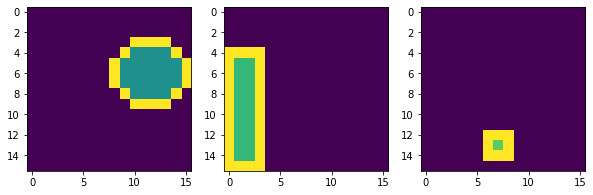

In [41]:
fig, subs = plt.subplots(1, 3, figsize=(10, 5))

for i in range(3):
    subs[i].imshow(draw_boundaries(LB, label=i + 1));

In [42]:
def perimeter(LB, label=1):
    return len(get_boundaries(LB, label))

In [43]:
def circularity(LB, label=1):
    # more circularity, less value
    return perimeter(LB, label)**2 / area(LB, label)

In [44]:
print(circularity(LB, 1))
print(circularity(LB, 2))
print(circularity(LB, 3))

7.363636363636363
16.333333333333332
7.111111111111111


In [47]:
def distance(px1, px2):
    return ((px1[0] - px2[0])**2 + (px1[1] - px2[1])**2)**0.5

def radial_distance(LB, label=1):
    r, c = centroid(LB, label)
    boundaries = get_boundaries(LB, label)
    K = len(boundaries)
    rd = 0
    
    for rk, ck in boundaries:
        rd += distance((r, c), (rk, ck))
    return rd / K

def std_radial(LB, label=1):
    r, c = centroid(LB, label)
    rd = radial_distance(LB, label)
    boundaries = get_boundaries(LB, label)
    K = len(boundaries)
    sr = 0
    
    for rk, ck in boundaries:
        sr += (distance((rk, ck), (r, c)) - rd)**2
    return (sr / K) ** 0.5

def circularity_std(LB, label=1):
    return radial_distance(LB, label) / std_radial(LB, label)

In [48]:
print(circularity_std(LB, 1))
print(circularity_std(LB, 2))
print(circularity_std(LB, 3))

15.38190804385473
2.494772261990279
5.828427124746188


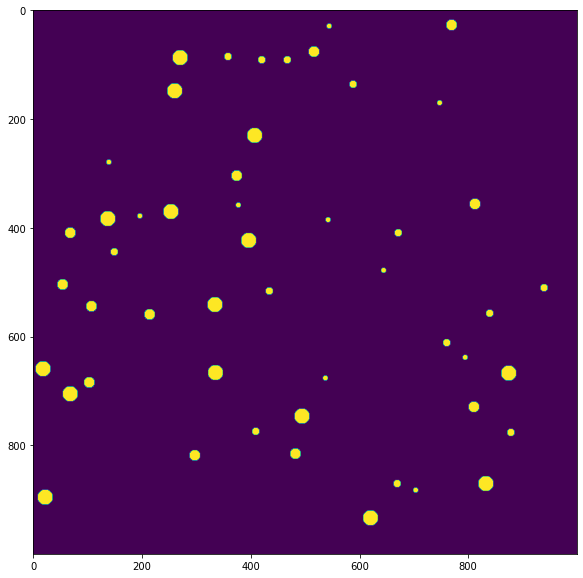

In [58]:
coins_img = np.load('coins.npy')
plt.figure(figsize=(10, 10))
plt.imshow(coins_img);

In [59]:
def check(image, y, x):
    if not 0 <= x < image.shape[1]:
        return False
    if not 0 <= y < image.shape[0]:
        return False
    if image[y,x] !=0:
        return True
    return False

def neighbours2(image,y,x):
    left = y, x-1
    top = y-1,x

    if not check(image, *left):
        left = None
    if not check(image, *top):
        top = None

    return left,top

def find(label,linked):
    j = int(label)
    while linked[j] != 0:
        j = linked[j]
    return j

def union(label1,label2,linked):
    j = find(label1,linked)
    k = find(label2,linked)
    if j != k:
        linked[k] = j
    


def two_pass_labeling(b_image):
    labeled = np.zeros_like(b_image)
    label = 1
    linked = np.zeros(len(b_image), dtype='uint')

    for y in range(b_image.shape[0]):
        for x in range(b_image.shape[1]):
            if b_image[y,x] != 0:
                ns = neighbours2(b_image,y,x)
                if ns[0] is None and ns[1] is None:
                    m = label
                    label += 1
                else:
                    lbs = [labeled[i] for i in ns if i is not None]
                    m = min(lbs)
                labeled[y,x] = m

                for n in ns:
                    if n is not None:
                        lb = labeled[n]
                        if lb != m:
                            union(m, lb, linked)

    labs = []
    
    for y in range(b_image.shape[0]):
        for x in range(b_image.shape[1]):
            if b_image[y,x] != 0:
                new_label = find(labeled[y,x],linked)
                
                if new_label != labeled[y,x]:
                    labeled[y,x] = new_label                    
                if new_label not in labs:
                    labs.append(new_label)
                if labeled[y,x] in labs:
                    labeled[y,x] = labs.index(new_label) + 1

    return labeled

In [101]:
coin_areas = dict()

In [96]:
marked = coins_img.copy() * -1
labeled = two_pass_labeling(marked)

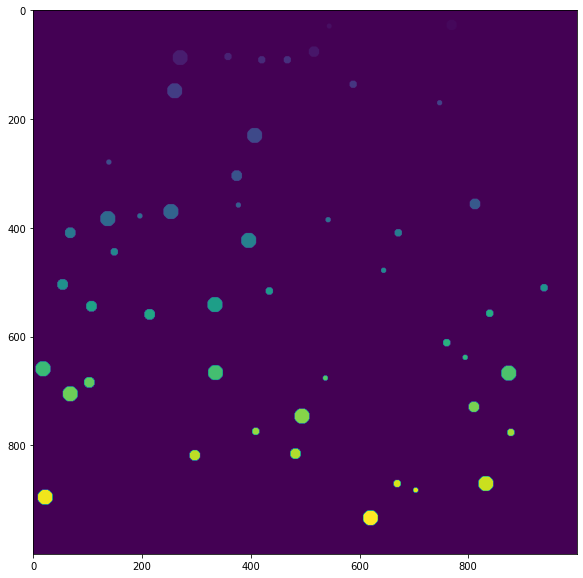

In [97]:
plt.figure(figsize=(10, 10))
plt.imshow(labeled)

In [102]:
for label in range(labeled.max()):
    c_area = area(labeled, label + 1)
    if c_area in coin_areas:
        coin_areas[c_area] += 1
    else:
        coin_areas[c_area] = 1

In [103]:
coin_areas

{305: 12, 69: 10, 609: 15, 145: 13}

In [104]:
nom = [1, 2, 5, 10]
s = 0

for i, key in enumerate(sorted(coin_areas.keys())):
    s += coin_areas[key] * nom[i]
print(f"Coin sum: {s}")

Coin sum: 246


In [105]:
from skimage.measure import label

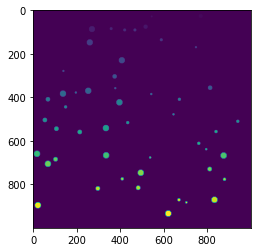

In [106]:
labeled = label(coins_img)

plt.imshow(labeled)